<a href="https://colab.research.google.com/github/yashb98/pytorch/blob/main/Pre_trained_models_Image_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell installs the `opendatasets` library, which is used to download datasets from online repositories like Kaggle.

In [29]:
# Install the 'opendatasets' library silently (without verbose output)
!pip install opendatasets --quiet

# Import the 'opendatasets' library to download datasets from Kaggle
import opendatasets as od

# Define the URL of the Kaggle dataset for bean leaf lesions classification
dataset_url = 'https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification'

# Download the dataset using the provided Kaggle URL
# This will prompt for your Kaggle username and API key
od.download(dataset_url)

Skipping, found downloaded files in "./bean-leaf-lesions-classification" (use force=True to force download)


This cell imports all the necessary libraries for this project, including PyTorch for building and training the model, torchvision for image handling and pre-trained models, pandas for data manipulation, and matplotlib for plotting.

In [30]:
# Importing required PyTorch modules for building and training the model
import torch
from torch import nn  # For neural network layers
from torch.optim import Adam  # Optimizer for training
from torch.utils.data import Dataset, DataLoader  # For custom dataset creation and batch loading

# Importing torchvision modules for image transformations and pre-trained models
from torchvision.transforms import transforms
from torchvision import models

# Importing LabelEncoder for converting class labels to numeric format
from sklearn.preprocessing import LabelEncoder

# For plotting graphs and visualizing data
import matplotlib.pyplot as plt

# For loading and handling image data
from PIL import Image

# For data manipulation and analysis
import pandas as pd
import numpy as np

# For interacting with the operating system (e.g., file paths)
import os

# Set device to GPU if available, else use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device  # Show which device is being used

'cuda'

Here, the training and validation datasets are loaded from CSV files into pandas DataFrames. The 'image:FILE' column is then updated to include the full path to the image files, which is required to load the images.

In [31]:
# Load the training dataset CSV into a DataFrame
train_df = pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')

# Load the validation dataset CSV into a DataFrame
val_df = pd.read_csv('/content/bean-leaf-lesions-classification/val.csv')

# Update the 'image:FILE' column in train_df to include the full file path
# This is necessary to load the images correctly
train_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + train_df['image:FILE']

# Do the same for the validation DataFrame
val_df['image:FILE'] = "/content/bean-leaf-lesions-classification/" + val_df['image:FILE']

# Display the first few rows of the training DataFrame to verify the changes
print(train_df.head())

# Print a separator for clarity
print("#" * 60)

# Display the first few rows of the validation DataFrame to verify the changes
print(val_df.head())

                                          image:FILE  category
0  /content/bean-leaf-lesions-classification/trai...         0
1  /content/bean-leaf-lesions-classification/trai...         0
2  /content/bean-leaf-lesions-classification/trai...         0
3  /content/bean-leaf-lesions-classification/trai...         0
4  /content/bean-leaf-lesions-classification/trai...         0
############################################################
                                          image:FILE  category
0  /content/bean-leaf-lesions-classification/val/...         0
1  /content/bean-leaf-lesions-classification/val/...         0
2  /content/bean-leaf-lesions-classification/val/...         0
3  /content/bean-leaf-lesions-classification/val/...         0
4  /content/bean-leaf-lesions-classification/val/...         0


This cell displays the dimensions (number of rows and columns) of the training and validation DataFrames, giving you an idea of the dataset size.

In [32]:
# Print the shapes of the training and validation DataFrames
# This shows the number of rows (samples) and columns in each DataFrame
train_df.shape, val_df.shape

((1034, 2), (133, 2))

This cell shows the unique values present in the 'category' column of both the training and validation DataFrames, which represent the different classes of bean leaf lesions.

In [33]:
# Print the unique values in the 'category' column for both training and validation DataFrames
# This shows the different classes present in the datasets
train_df['category'].unique(), val_df['category'].unique()

(array([0, 1, 2]), array([0, 1, 2]))

This cell counts how many images belong to each category in the training dataset and also determines the total number of unique categories.

In [34]:
# Count the occurrences of each unique value in the 'category' column of the training DataFrame
# This helps understand the class distribution in the training set
train_df['category'].value_counts()

# Determine the number of unique classes in the training dataset
num_classes = len(train_df['category'].unique())
# Print the number of classes
num_classes

3

This cell defines a sequence of image transformations to be applied to the images. These transformations include resizing the images to a fixed size (224x224), converting them to PyTorch tensors, and ensuring they have the correct data type.

In [35]:
# Define a sequence of image transformations to be applied to the images
transform = transforms.Compose([
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    # Convert the image to a PyTorch Tensor
    transforms.ToTensor(),
    # Convert the image tensor to the specified data type (float)
    transforms.ConvertImageDtype(torch.float),
    ])

This cell defines a custom PyTorch `Dataset` class. This class is responsible for loading the images and their corresponding labels from the DataFrame and applying the defined transformations.

In [36]:
# Define a custom PyTorch Dataset class for loading images and their corresponding labels
class CustomImageDataset(Dataset):
    # Initialize the dataset with a DataFrame and an optional transform
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # Store the labels as a PyTorch tensor on the specified device (GPU or CPU)
        self.labels = torch.tensor(dataframe['category']).to(device)


    # Return the total number of samples in the dataset
    def __len__(self):
      return self.dataframe.shape[0]

    # Get a sample from the dataset at the given index
    def __getitem__(self, idx):
      # Get the image file path from the DataFrame
      img_path = self.dataframe.iloc[idx, 0]
      # Get the label for the image
      label = self.labels[idx]
      # Open the image file
      image = Image.open(img_path)

      # Apply the transformations if provided
      if self.transform:
        # Apply the transform and normalize the pixel values to the range [0, 1]
        # Move the transformed image tensor to the specified device
        image= (self.transform(image)/255.0).to(device)
      # Return the transformed image and its label
      return image, label

Instances of the `CustomImageDataset` are created for both the training and validation DataFrames, applying the defined image transformations.

In [37]:
# Create instances of the CustomImageDataset for the training and validation DataFrames
# Apply the defined transformations to both datasets
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)

This cell visualizes a few random images from the training dataset to give you a visual sense of the data.

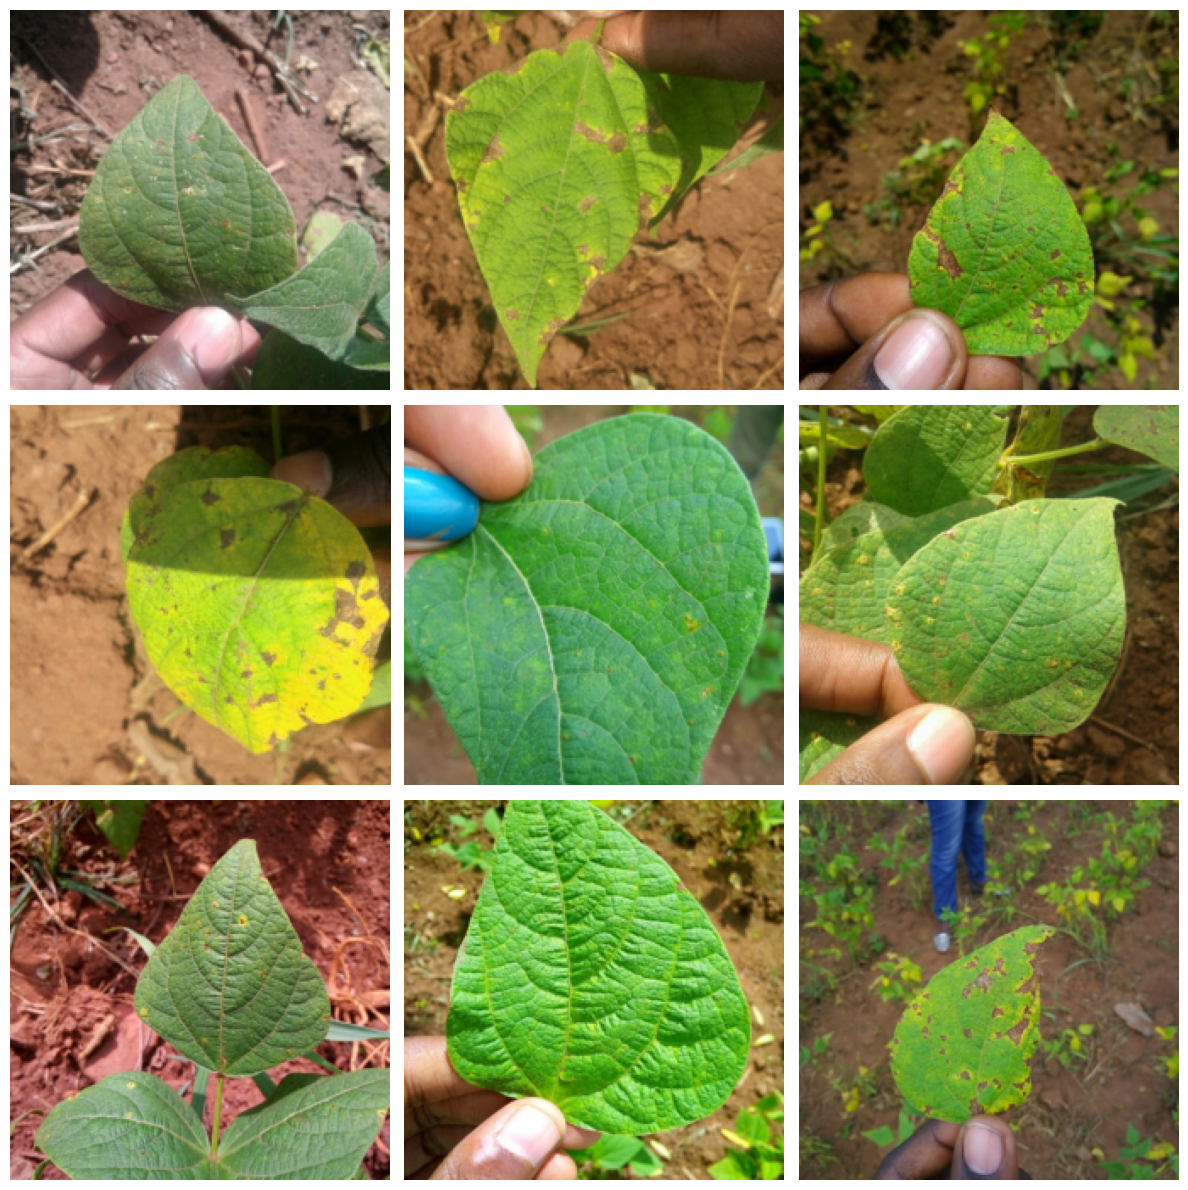

In [38]:
# Define the number of rows and columns for the plot
n_rows = 3
n_cols = 3

# Create a figure and a set of subplots
f, ax = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Iterate through the rows and columns to display images
for row in range(n_rows):
  for col in range(n_cols):
    # Get a random image and its label from the training dataset
    # Move the image tensor to the CPU for plotting
    image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu()
    # Display the image in the current subplot
    # Permute the dimensions to (height, width, channels) for matplotlib
    ax[row, col].imshow((image*255.0).squeeze().permute(1, 2, 0))
    # Turn off the axis for the subplot
    ax[row, col].axis('off')
# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()
# Display the plot
plt.show()

This cell sets the hyperparameters for the model training process, such as the learning rate, batch size, and the number of training epochs.

In [39]:
# Define hyperparameters for training the model
LR = 0.001       # Learning rate for the optimizer
BATCH_SIZE = 4   # Number of samples per batch
EPOCHS = 15      # Number of training epochs

`DataLoader` objects are created for the training and validation datasets. These loaders help in efficiently iterating over the datasets in batches during training and evaluation. The training data is shuffled, while the validation data is not.

In [40]:
# Create DataLoaders for the training and validation datasets
# DataLoaders help in iterating over the dataset in batches
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # Do not shuffle validation data

A GoogLeNet model pretrained on the ImageNet dataset is loaded from `torchvision.models`.

In [41]:
# Load a pretrained GoogLeNet model from torchvision.models
# pretrained=True downloads the model weights trained on ImageNet
googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


This cell sets the `requires_grad` attribute to `True` for all parameters in the loaded GoogLeNet model. This means that the weights of all layers will be updated during the training process.

In [42]:
# Iterate through all parameters of the GoogLeNet model
for param in googlenet.parameters():
  # Set requires_grad to True for all parameters
  # This allows the gradients to be computed for all layers during training
  param.requires_grad = True

This cell displays the structure of the fully connected layer (the final classification layer) of the GoogLeNet model.

In [43]:
# Access the fully connected layer (classifier) of the GoogLeNet model
googlenet.fc

Linear(in_features=1024, out_features=1000, bias=True)

This cell re-calculates and prints the number of unique classes in the training dataset.

In [44]:
# Recalculate the number of unique classes in the training dataset
num_classes = len(train_df['category'].unique())
# Print the number of classes
num_classes

3

The original fully connected layer of the GoogLeNet model is replaced with a new linear layer that has the same input features but the number of output features equal to the number of classes in our specific dataset.

In [45]:
# Replace the original fully connected layer with a new one
# The new layer has the same number of input features as the original,
# but the number of output features is set to the number of classes in our dataset
googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, num_classes)

# Print the modified fully connected layer to verify the change
googlenet.fc

Linear(in_features=1024, out_features=3, bias=True)

The entire GoogLeNet model (with the modified final layer) is moved to the specified device (GPU or CPU) for training.

In [46]:
# Move the GoogLeNet model to the specified device (GPU or CPU)
googlenet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

This cell defines the loss function (Cross-Entropy Loss) and the optimizer (Adam) used for training the model. It then enters the training loop, iterating through epochs and batches, calculating the loss and accuracy, and updating the model's weights.

In [47]:
# Define the loss function to be used for training (Cross-Entropy Loss)
loss_fun = nn.CrossEntropyLoss()
# Define the optimizer (Adam) and pass the model parameters and learning rate
optimizer = Adam(googlenet.parameters(), lr=LR)

# Initialize lists to store training loss and accuracy for plotting
total_loss_train_plot = []
total_acc_train_plot = []

# Start the training loop for the specified number of epochs
for epoch in range(EPOCHS):
  # Initialize variables to accumulate training accuracy and loss for the current epoch
  total_acc_train = 0
  total_loss_train = 0

  # Iterate over the training data in batches
  for inputs, lables in train_loader:
    # Zero the gradients of the optimizer
    optimizer.zero_grad()
    # Forward pass: get the model's predictions
    outputs = googlenet(inputs)
    # Calculate the training loss
    train_loss = loss_fun(outputs, lables)
    # Accumulate the training loss
    total_loss_train += train_loss.item()
    # Backward pass: compute the gradients
    train_loss.backward()

    # Calculate the training accuracy for the current batch
    train_acc = (torch.argmax(outputs, axis=1) == lables).sum().item()
    # Accumulate the training accuracy
    total_acc_train += train_acc
    # Update the model's weights
    optimizer.step()

  # Append the average training loss and accuracy for the epoch to the lists
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()* 100, 4))
  # Print the training loss and accuracy for the current epoch
  print(f"""
  Epochs: {epoch+1}/{EPOCHS}
  Training Loss: {round(total_loss_train/1000, 4)}
  Training Accuracy: {round(total_acc_train/train_dataset.__len__()* 100, 4)}
  """)


  Epochs: 1/15
  Training Loss: 0.2286
  Training Accuracy: 60.6383
  

  Epochs: 2/15
  Training Loss: 0.1805
  Training Accuracy: 69.9226
  

  Epochs: 3/15
  Training Loss: 0.1671
  Training Accuracy: 73.1141
  

  Epochs: 4/15
  Training Loss: 0.1481
  Training Accuracy: 76.9826
  

  Epochs: 5/15
  Training Loss: 0.1309
  Training Accuracy: 79.4971
  

  Epochs: 6/15
  Training Loss: 0.1158
  Training Accuracy: 82.7853
  

  Epochs: 7/15
  Training Loss: 0.1116
  Training Accuracy: 82.3017
  

  Epochs: 8/15
  Training Loss: 0.1098
  Training Accuracy: 82.9787
  

  Epochs: 9/15
  Training Loss: 0.1038
  Training Accuracy: 84.3327
  

  Epochs: 10/15
  Training Loss: 0.0951
  Training Accuracy: 85.2031
  

  Epochs: 11/15
  Training Loss: 0.099
  Training Accuracy: 85.2998
  

  Epochs: 12/15
  Training Loss: 0.0905
  Training Accuracy: 87.5242
  

  Epochs: 13/15
  Training Loss: 0.0751
  Training Accuracy: 88.3946
  

  Epochs: 14/15
  Training Loss: 0.0705
  Training Accuracy:

This cell defines a function `train_and_evaluate` that handles the training and evaluation process for a given model and hyperparameters. It also sets up a loop to run experiments with different sets of hyperparameters defined in the `hyperparameters` list, training and evaluating the model for each set. Finally, it identifies the experiment with the best validation accuracy.

In [48]:
# Define a function to train and evaluate a model
def train_and_evaluate(model, train_loader, val_loader, loss_function, optimizer, epochs, device):
  """
  Trains and evaluates the model with given hyperparameters.

  Args:
    model: The neural network model.
    train_loader: DataLoader for the training set.
    val_loader: DataLoader for the validation set.
    loss_function: The loss function to use.
    optimizer: The optimizer to use.
    epochs: Number of training epochs.
    device: The device to train on ('cuda' or 'cpu').

  Returns:
    A tuple containing:
      - List of training losses per epoch.
      - List of training accuracies per epoch.
      - List of validation losses per epoch.
      - List of validation accuracies per epoch.
  """
  # Initialize lists to store losses and accuracies for training and validation
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  # Iterate through the specified number of epochs
  for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    # Initialize variables to accumulate training loss and accuracy for the epoch
    total_train_loss = 0
    total_train_acc = 0

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
      # Move inputs and labels to the specified device
      inputs, labels = inputs.to(device), labels.to(device)
      # Zero the gradients of the optimizer
      optimizer.zero_grad()
      # Forward pass: get the model's predictions
      outputs = model(inputs)
      # Calculate the loss
      loss = loss_function(outputs, labels)
      # Accumulate the training loss
      total_train_loss += loss.item()
      # Backward pass: compute the gradients
      loss.backward()
      # Update the model's weights
      optimizer.step()

      # Get the predicted class by finding the index with the maximum probability
      _, predicted = torch.max(outputs.data, 1)
      # Accumulate the training accuracy
      total_train_acc += (predicted == labels).sum().item()

    # Calculate the average training loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader.dataset)
    # Append the average training loss and accuracy to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables to accumulate validation loss and accuracy for the epoch
    total_val_loss = 0
    total_val_acc = 0
    # Disable gradient computation during validation
    with torch.no_grad():
      # Iterate over the validation data in batches
      for inputs, labels in val_loader:
        # Move inputs and labels to the specified device
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass: get the model's predictions
        outputs = model(inputs)
        # Calculate the loss
        loss = loss_function(outputs, labels)
        # Accumulate the validation loss
        total_val_loss += loss.item()

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        # Accumulate the validation accuracy
        total_val_acc += (predicted == labels).sum().item()

    # Calculate the average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader.dataset)
    # Append the average validation loss and accuracy to the lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    # Print the training and validation loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")
    print("-" * 30)

  # Return the lists of losses and accuracies
  return train_losses, train_accuracies, val_losses, val_accuracies

# Define different sets of hyperparameters to experiment with
hyperparameters = [
    {'loss_function': nn.CrossEntropyLoss(), 'optimizer': Adam, 'lr': 0.001, 'batch_size': 32, 'epochs': 20},
    {'loss_function': nn.NLLLoss(), 'optimizer': Adam, 'lr': 0.001, 'batch_size': 32, 'epochs': 20}, # Need to adjust model output for NLLLoss
    {'loss_function': nn.CrossEntropyLoss(), 'optimizer': torch.optim.SGD, 'lr': 0.01, 'batch_size': 64, 'epochs': 30},
    {'loss_function': nn.CrossEntropyLoss(), 'optimizer': Adam, 'lr': 0.0005, 'batch_size': 16, 'epochs': 25},
]

# Dictionary to store the results of each hyperparameter experiment
results = {}

# Iterate through each set of hyperparameters
for i, params in enumerate(hyperparameters):
  print(f"Experiment {i+1}:")
  print(f"  Loss Function: {type(params['loss_function']).__name__}")
  print(f"  Optimizer: {params['optimizer'].__name__}")
  print(f"  Learning Rate: {params['lr']}")
  print(f"  Batch Size: {params['batch_size']}")
  print(f"  Epochs: {params['epochs']}")

  # Re-initialize the model for each experiment to avoid carry-over effects
  # Load a pretrained GoogLeNet model
  model = models.googlenet(pretrained=True)
  # Set all parameters to require gradients initially
  for param in model.parameters():
      param.requires_grad = True
  # Get the number of classes
  num_classes = len(train_df['category'].unique())
  # Replace the fully connected layer
  model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

  # Adjust model output if using NLLLoss by adding a LogSoftmax layer
  if isinstance(params['loss_function'], nn.NLLLoss):
      model = nn.Sequential(model, nn.LogSoftmax(dim=1)) # Add LogSoftmax for NLLLoss

  # Move the model to the specified device
  model.to(device)

  # Define the optimizer with the current hyperparameters
  optimizer = params['optimizer'](model.parameters(), lr=params['lr'])

  # Create DataLoaders with the current batch size
  train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

  # Train and evaluate the model with the current hyperparameters
  train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate(
      model,
      train_loader,
      val_loader,
      params['loss_function'],
      optimizer,
      params['epochs'],
      device
  )

  # Store the results of the experiment
  results[f'Experiment_{i+1}'] = {
      'hyperparameters': params,
      'train_losses': train_losses,
      'train_accuracies': train_accuracies,
      'val_losses': val_losses,
      'val_accuracies': val_accuracies
  }
  print("=" * 50)

# After running all experiments, you can analyze the results in the 'results' dictionary
# to find the combination of hyperparameters that yields the lowest validation loss and highest validation accuracy.

# Example of how to plot results for a single experiment:
# experiment_key = 'Experiment_1'
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(results[experiment_key]['train_losses'], label='Train Loss')
# plt.plot(results[experiment_key]['val_losses'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title(f'Loss over Epochs ({experiment_key})')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(results[experiment_key]['train_accuracies'], label='Train Accuracy')
# plt.plot(results[experiment_key]['val_accuracies'], label='Val Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title(f'Accuracy over Epochs ({experiment_key})')
# plt.legend()

# plt.show()

# To find the best experiment, you can iterate through the results:
best_val_acc = -1
best_experiment = None

# Iterate through the results to find the experiment with the highest final validation accuracy
for key, value in results.items():
  last_val_acc = value['val_accuracies'][-1]
  if last_val_acc > best_val_acc:
    best_val_acc = last_val_acc
    best_experiment = key

# Print the best experiment and its details
print(f"The best experiment is: {best_experiment}")
print(f"With final validation accuracy: {best_val_acc:.4f}")
print("Hyperparameters for the best experiment:")
print(results[best_experiment]['hyperparameters'])

Experiment 1:
  Loss Function: CrossEntropyLoss
  Optimizer: Adam
  Learning Rate: 0.001
  Batch Size: 32
  Epochs: 20


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20:
  Train Loss: 0.6182, Train Acc: 0.7282
  Val Loss: 1.1099, Val Acc: 0.3383
------------------------------
Epoch 2/20:
  Train Loss: 0.3350, Train Acc: 0.8752
  Val Loss: 1.1768, Val Acc: 0.3383
------------------------------
Epoch 3/20:
  Train Loss: 0.2717, Train Acc: 0.8936
  Val Loss: 1.1612, Val Acc: 0.5789
------------------------------
Epoch 4/20:
  Train Loss: 0.2027, Train Acc: 0.9217
  Val Loss: 1.0653, Val Acc: 0.3308
------------------------------
Epoch 5/20:
  Train Loss: 0.1733, Train Acc: 0.9323
  Val Loss: 1.1880, Val Acc: 0.3383
------------------------------
Epoch 6/20:
  Train Loss: 0.1727, Train Acc: 0.9323
  Val Loss: 1.3141, Val Acc: 0.3308
------------------------------
Epoch 7/20:
  Train Loss: 0.1081, Train Acc: 0.9623
  Val Loss: 1.3312, Val Acc: 0.3308
------------------------------
Epoch 8/20:
  Train Loss: 0.0658, Train Acc: 0.9787
  Val Loss: 1.3651, Val Acc: 0.3308
------------------------------
Epoch 9/20:
  Train Loss: 0.0575, Train Acc: 0.9

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20:
  Train Loss: 0.6027, Train Acc: 0.7292
  Val Loss: 1.3122, Val Acc: 0.3308
------------------------------
Epoch 2/20:
  Train Loss: 0.3575, Train Acc: 0.8578
  Val Loss: 2.3572, Val Acc: 0.3308
------------------------------
Epoch 3/20:
  Train Loss: 0.2448, Train Acc: 0.8985
  Val Loss: 2.0018, Val Acc: 0.3383
------------------------------
Epoch 4/20:
  Train Loss: 0.2120, Train Acc: 0.9304
  Val Loss: 1.5512, Val Acc: 0.3534
------------------------------
Epoch 5/20:
  Train Loss: 0.1860, Train Acc: 0.9255
  Val Loss: 1.7252, Val Acc: 0.3383
------------------------------
Epoch 6/20:
  Train Loss: 0.0914, Train Acc: 0.9710
  Val Loss: 1.4866, Val Acc: 0.4812
------------------------------
Epoch 7/20:
  Train Loss: 0.0796, Train Acc: 0.9758
  Val Loss: 1.9950, Val Acc: 0.3383
------------------------------
Epoch 8/20:
  Train Loss: 0.1522, Train Acc: 0.9458
  Val Loss: 1.1198, Val Acc: 0.3383
------------------------------
Epoch 9/20:
  Train Loss: 0.1206, Train Acc: 0.9

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30:
  Train Loss: 1.0749, Train Acc: 0.3926
  Val Loss: 1.2385, Val Acc: 0.3308
------------------------------
Epoch 2/30:
  Train Loss: 0.9431, Train Acc: 0.5928
  Val Loss: 1.0893, Val Acc: 0.3308
------------------------------
Epoch 3/30:
  Train Loss: 0.8162, Train Acc: 0.6925
  Val Loss: 1.2465, Val Acc: 0.3308
------------------------------
Epoch 4/30:
  Train Loss: 0.6971, Train Acc: 0.7621
  Val Loss: 1.2986, Val Acc: 0.3534
------------------------------
Epoch 5/30:
  Train Loss: 0.5935, Train Acc: 0.8095
  Val Loss: 1.1582, Val Acc: 0.4060
------------------------------
Epoch 6/30:
  Train Loss: 0.4883, Train Acc: 0.8433
  Val Loss: 1.3112, Val Acc: 0.3910
------------------------------
Epoch 7/30:
  Train Loss: 0.4018, Train Acc: 0.8772
  Val Loss: 1.2122, Val Acc: 0.3308
------------------------------
Epoch 8/30:
  Train Loss: 0.3411, Train Acc: 0.9052
  Val Loss: 1.1144, Val Acc: 0.3684
------------------------------
Epoch 9/30:
  Train Loss: 0.2974, Train Acc: 0.9

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25:
  Train Loss: 0.5992, Train Acc: 0.7408
  Val Loss: 1.1267, Val Acc: 0.3534
------------------------------
Epoch 2/25:
  Train Loss: 0.3384, Train Acc: 0.8714
  Val Loss: 1.3626, Val Acc: 0.3308
------------------------------
Epoch 3/25:
  Train Loss: 0.2549, Train Acc: 0.9014
  Val Loss: 1.0101, Val Acc: 0.4962
------------------------------
Epoch 4/25:
  Train Loss: 0.1834, Train Acc: 0.9371
  Val Loss: 1.3362, Val Acc: 0.3383
------------------------------
Epoch 5/25:
  Train Loss: 0.1948, Train Acc: 0.9255
  Val Loss: 1.4477, Val Acc: 0.3383
------------------------------
Epoch 6/25:
  Train Loss: 0.1265, Train Acc: 0.9555
  Val Loss: 0.6555, Val Acc: 0.7368
------------------------------
Epoch 7/25:
  Train Loss: 0.1174, Train Acc: 0.9497
  Val Loss: 1.4714, Val Acc: 0.3383
------------------------------
Epoch 8/25:
  Train Loss: 0.0486, Train Acc: 0.9874
  Val Loss: 1.5553, Val Acc: 0.3383
------------------------------
Epoch 9/25:
  Train Loss: 0.0941, Train Acc: 0.9

This cell evaluates the previously trained GoogLeNet model on the validation dataset to calculate its final accuracy. `torch.no_grad()` is used to disable gradient calculation during evaluation, saving computation.

In [49]:
# Evaluate the model on the validation set (referred to as test set in the variable names)
with torch.no_grad(): # Disable gradient computation for evaluation
  total_loss_test = 0 # Initialize total test loss (not used in this cell but kept for consistency)
  total_acc_test = 0 # Initialize total test accuracy

  # Iterate over the validation data in batches
  for input, labels in val_loader:
    # Get the model's predictions
    predictions = googlenet(input)

    # Calculate the test accuracy for the current batch
    test_acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    # Accumulate the test accuracy
    total_acc_test += test_acc

This cell prints the final calculated accuracy of the GoogLeNet model on the validation set.

In [50]:
# Print the final test accuracy
# Divide the total accumulated accuracy by the number of samples in the validation dataset
print(f"Test Accuracy: {round(total_acc_test/val_dataset.__len__()*100, 4)}%")

Test Accuracy: 73.6842%


This markdown cell introduces the concept of using transfer learning, where a model pre-trained on a large dataset is adapted for a new task.

## Transfer Learning

This cell loads a pretrained GoogLeNet model again, but this time all its layers except the final fully connected layer are frozen (their weights will not be updated during training). This is a common approach in transfer learning to leverage the learned features from the original task.

In [51]:
# Load a pretrained GoogLeNet model with default weights for transfer learning
googlenet = models.googlenet(weights='DEFAULT')

# Freeze all the parameters of the pretrained model
# This prevents their weights from being updated during training
for params in googlenet.parameters():
  params.requires_grad = False

# Replace the fully connected layer with a new one for the specific number of classes
googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, num_classes)
# Unfreeze the parameters of the new fully connected layer
# Only this layer will be trained
googlenet.fc.requires_grad= True
# Move the model to the specified device (GPU or CPU)
googlenet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

This cell defines the loss function and optimizer for the transfer learning model. The optimizer is configured to only update the parameters of the unfrozen final layer. The code then trains this transfer learning model.

In [52]:
# Define the loss function (Cross-Entropy Loss)
loss_fun = nn.CrossEntropyLoss()
# Define the optimizer (Adam) and pass the parameters of the model that require gradients (only the new fc layer) and the learning rate
optimizer = Adam(googlenet.parameters(), lr=LR)

# Initialize lists to store training loss and accuracy for plotting
total_loss_train_plot = []
total_acc_train_plot = []

# Start the training loop for the specified number of epochs
for epoch in range(EPOCHS):
  # Initialize variables to accumulate training accuracy and loss for the current epoch
  total_acc_train = 0
  total_loss_train = 0

  # Iterate over the training data in batches
  for inputs, lables in train_loader:
    # Zero the gradients of the optimizer
    optimizer.zero_grad()
    # Forward pass: get the model's predictions
    outputs = googlenet(inputs)
    # Calculate the training loss
    train_loss = loss_fun(outputs, lables)
    # Accumulate the training loss
    total_loss_train += train_loss.item()
    # Backward pass: compute the gradients
    train_loss.backward()

    # Calculate the training accuracy for the current batch
    train_acc = (torch.argmax(outputs, axis=1) == lables).sum().item()
    # Accumulate the training accuracy
    total_acc_train += train_acc
    # Update the model's weights
    optimizer.step()

  # Append the average training loss and accuracy for the epoch to the lists
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()* 100, 4))
  # Print the training loss and accuracy for the current epoch
  print(f"""
  Epochs: {epoch+1}/{EPOCHS}
  Training Loss: {round(total_loss_train/1000, 4)}
  Training Accuracy: {round(total_acc_train/train_dataset.__len__()* 100, 4)}
  """)


  Epochs: 1/15
  Training Loss: 0.0673
  Training Accuracy: 46.4217
  

  Epochs: 2/15
  Training Loss: 0.0602
  Training Accuracy: 55.9961
  

  Epochs: 3/15
  Training Loss: 0.0548
  Training Accuracy: 61.6054
  

  Epochs: 4/15
  Training Loss: 0.0525
  Training Accuracy: 67.2147
  

  Epochs: 5/15
  Training Loss: 0.0503
  Training Accuracy: 66.7311
  

  Epochs: 6/15
  Training Loss: 0.0485
  Training Accuracy: 68.472
  

  Epochs: 7/15
  Training Loss: 0.0475
  Training Accuracy: 70.0193
  

  Epochs: 8/15
  Training Loss: 0.0455
  Training Accuracy: 69.9226
  

  Epochs: 9/15
  Training Loss: 0.0445
  Training Accuracy: 71.8569
  

  Epochs: 10/15
  Training Loss: 0.0448
  Training Accuracy: 70.3095
  

  Epochs: 11/15
  Training Loss: 0.045
  Training Accuracy: 70.6963
  

  Epochs: 12/15
  Training Loss: 0.0439
  Training Accuracy: 70.0193
  

  Epochs: 13/15
  Training Loss: 0.0418
  Training Accuracy: 72.7273
  

  Epochs: 14/15
  Training Loss: 0.0448
  Training Accuracy: 

This cell evaluates the transfer learning model on the validation dataset to calculate its accuracy.

In [53]:
# Evaluate the model on the validation set (referred to as test set in the variable names)
with torch.no_grad(): # Disable gradient computation for evaluation
  total_loss_test = 0 # Initialize total test loss (not used in this cell but kept for consistency)
  total_acc_test = 0 # Initialize total test accuracy

  # Iterate over the validation data in batches
  for input, labels in val_loader:
    # Get the model's predictions
    predictions = googlenet(input)

    # Calculate the test accuracy for the current batch
    test_acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    # Accumulate the test accuracy
    total_acc_test += test_acc

This cell prints the final calculated accuracy of the transfer learning model.

In [54]:
# Print the final test accuracy for the transfer learning model
# Divide the total accumulated accuracy by the number of samples in the validation dataset
print(f"Test Accuracy: {round(total_acc_test/val_dataset.__len__()*100, 4)}%")

Test Accuracy: 42.1053%


This cell sets up an experiment to compare the performance of several different pretrained vision models (ResNet18, ResNet50, VGG16, DenseNet121, EfficientNet_B0, and GoogLeNet) using the transfer learning approach. It loads each model, freezes most layers, replaces the classifier, and trains and evaluates it using the `train_and_evaluate` function. The results are stored and a summary of the final performance for each model is printed, identifying the best performing model based on validation accuracy.

In [55]:
# prompt: try using different pretrained vison models so that we can gett better accuracy for both training and testing  and import those models as well

import torchvision.models as models
from torch import nn

# Define a dictionary of different pretrained vision models to experiment with
pretrained_models = {
    'ResNet18': models.resnet18,
    'ResNet50': models.resnet50,
    'VGG16': models.vgg16,
    'DenseNet121': models.densenet121,
    'EfficientNet_B0': models.efficientnet_b0,
    'GoogLeNet': models.googlenet
}

# Dictionary to store the results for each model experiment
model_results = {}

# Iterate through each pretrained model
for model_name, model_fn in pretrained_models.items():
    print(f"\nExperimenting with {model_name}:")

    # Load the pretrained model with default weights
    model = model_fn(weights='DEFAULT')

    # Freeze all layers initially by setting requires_grad to False
    for param in model.parameters():
        param.requires_grad = False

    # Modify the classifier/last layer to match the number of classes in our dataset
    if hasattr(model, 'fc'): # Handle models like ResNet, GoogLeNet
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.fc.requires_grad = True # Unfreeze the new layer for training
    elif hasattr(model, 'classifier'): # Handle models like VGG, DenseNet, EfficientNet
        if isinstance(model.classifier, nn.Sequential): # Handle Sequential classifiers (VGG, DenseNet)
            num_ftrs = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
            model.classifier[-1].requires_grad = True # Unfreeze the new layer
        else: # Handle other classifier structures (EfficientNet)
             num_ftrs = model.classifier.in_features
             model.classifier = nn.Linear(num_ftrs, num_classes)
             model.classifier.requires_grad = True # Unfreeze the new layer
    else:
        # Print a warning if the classifier structure is not recognized and skip the model
        print(f"Warning: Could not automatically find classifier for {model_name}. Manual inspection needed.")
        continue # Skip this model for now if the structure is unexpected

    # Move the model to the specified device (GPU or CPU)
    model.to(device)

    # Define loss function (Cross-Entropy Loss) and optimizer (Adam)
    loss_function = nn.CrossEntropyLoss()
    # Only optimize parameters that require gradients (the unfrozen layers, which is the new classifier)
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

    print("Starting training...")
    # Train and evaluate the model using the defined function
    train_losses, train_accuracies, val_losses, val_accuracies = train_and_evaluate(
        model,
        train_loader,
        val_loader,
        loss_function,
        optimizer,
        EPOCHS,
        device
    )

    # Store the training and validation results for the current model
    model_results[model_name] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
    print("=" * 50)

# Analyze and print results for each model
print("\n--- Model Performance Summary ---")
best_model_name = None
best_overall_val_acc = -1

# Iterate through the results of each model to find the best performing one
for model_name, results in model_results.items():
    # Get the final training and validation accuracy and loss
    final_train_acc = results['train_accuracies'][-1] if results['train_accuracies'] else 0
    final_val_acc = results['val_accuracies'][-1] if results['val_accuracies'] else 0
    final_train_loss = results['train_losses'][-1] if results['train_losses'] else float('inf')
    final_val_loss = results['val_losses'][-1] if results['val_losses'] else float('inf')

    # Print the performance metrics for the current model
    print(f"\n{model_name}:")
    print(f"  Final Train Loss: {final_train_loss:.4f}, Final Train Acc: {final_train_acc:.4f}")
    print(f"  Final Val Loss: {final_val_loss:.4f}, Final Val Acc: {final_val_acc:.4f}")

    # Check if the current model has the best validation accuracy so far
    if final_val_acc > best_overall_val_acc:
        best_overall_val_acc = final_val_acc
        best_model_name = model_name

# Print the overall best performing model based on validation accuracy
print("\n--- Overall Best Model ---")
if best_model_name:
    print(f"The model with the best final validation accuracy is: {best_model_name}")
    print(f"Best Final Validation Accuracy: {best_overall_val_acc:.4f}")
else:
    print("No model results to display.")

# You can also plot the results for each model for better visualization if needed
# For example:
# for model_name, results in model_results.items():
#     plt.figure(figsize=(12, 5))
#
#     plt.subplot(1, 2, 1)
#     plt.plot(results['train_losses'], label='Train Loss')
#     plt.plot(results['val_losses'], label='Val Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title(f'Loss over Epochs ({model_name})')
#     plt.legend()
#
#     plt.subplot(1, 2, 2)
#     plt.plot(results['train_accuracies'], label='Train Accuracy')
#     plt.plot(results['val_accuracies'], label='Val Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title(f'Accuracy over Epochs ({model_name})')
#     plt.legend()
#
#     plt.show()


Experimenting with ResNet18:
Starting training...
Epoch 1/15:
  Train Loss: 0.8472, Train Acc: 0.6074
  Val Loss: 1.2029, Val Acc: 0.3308
------------------------------
Epoch 2/15:
  Train Loss: 0.5825, Train Acc: 0.7901
  Val Loss: 0.4715, Val Acc: 0.8647
------------------------------
Epoch 3/15:
  Train Loss: 0.4996, Train Acc: 0.8201
  Val Loss: 0.3922, Val Acc: 0.8722
------------------------------
Epoch 4/15:
  Train Loss: 0.4829, Train Acc: 0.8182
  Val Loss: 0.3584, Val Acc: 0.9023
------------------------------
Epoch 5/15:
  Train Loss: 0.4574, Train Acc: 0.8230
  Val Loss: 0.3208, Val Acc: 0.9248
------------------------------
Epoch 6/15:
  Train Loss: 0.4026, Train Acc: 0.8453
  Val Loss: 0.3362, Val Acc: 0.8647
------------------------------
Epoch 7/15:
  Train Loss: 0.3704, Train Acc: 0.8665
  Val Loss: 0.2931, Val Acc: 0.9248
------------------------------
Epoch 8/15:
  Train Loss: 0.3390, Train Acc: 0.8888
  Val Loss: 0.3262, Val Acc: 0.8647
----------------------------

This cell generates plots of the training and validation loss and accuracy over epochs for each of the pretrained models that were experimented with in the previous cell. This provides a visual comparison of how each model performed during training.

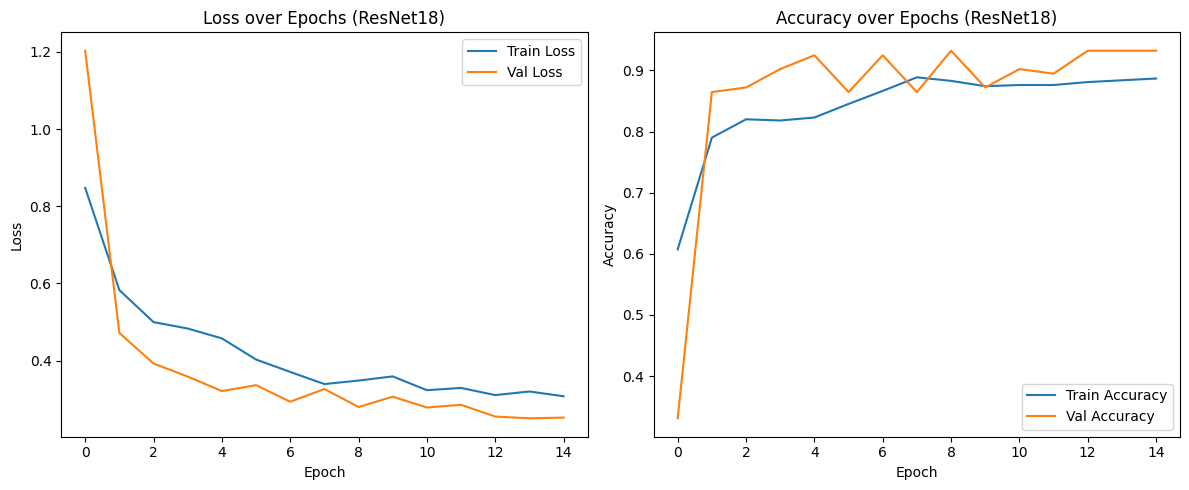

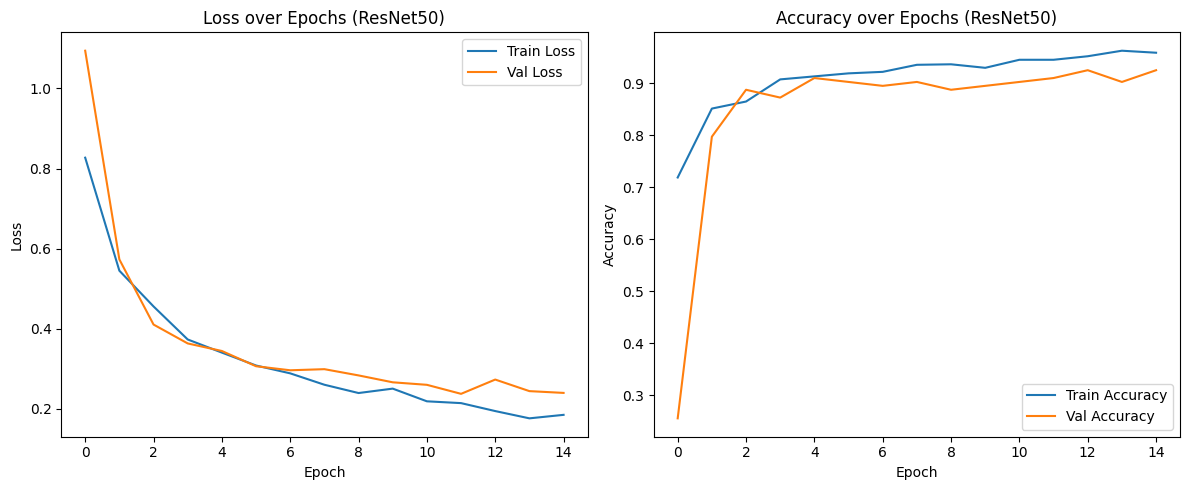

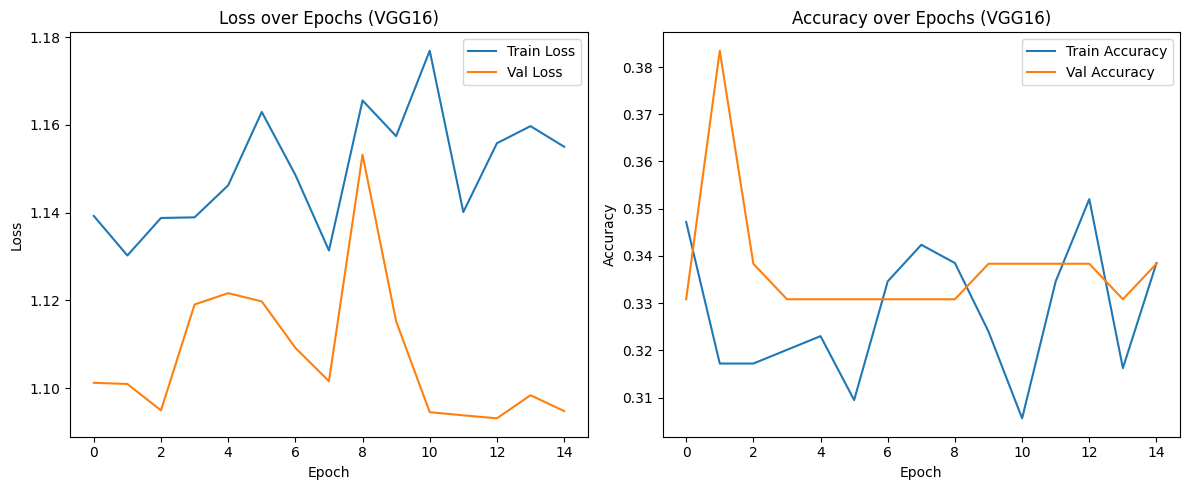

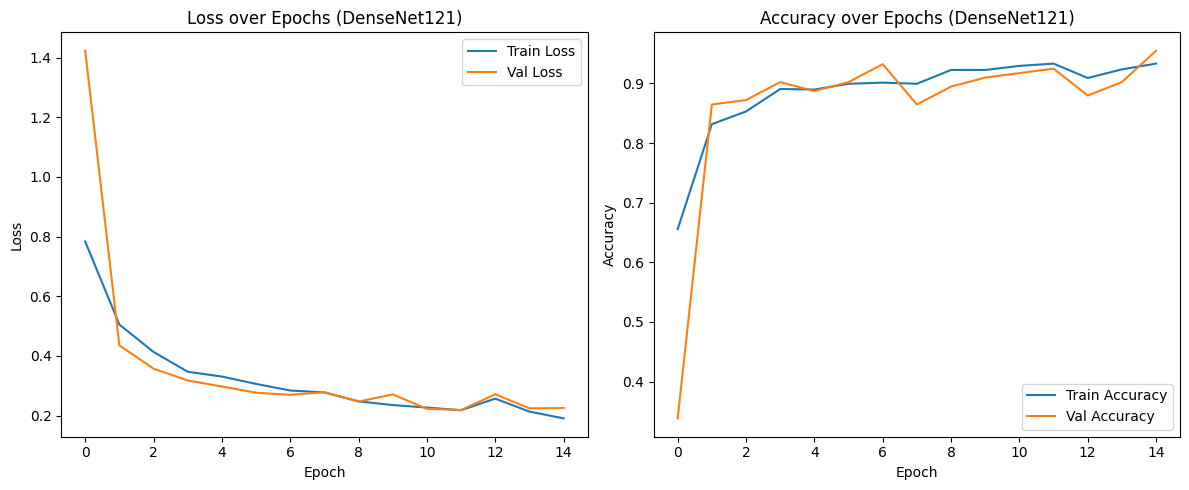

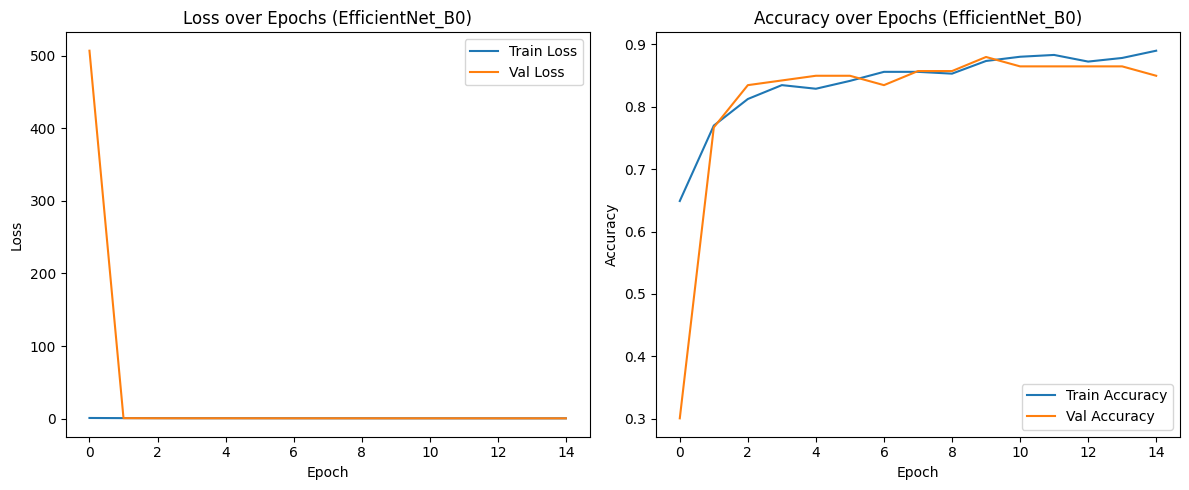

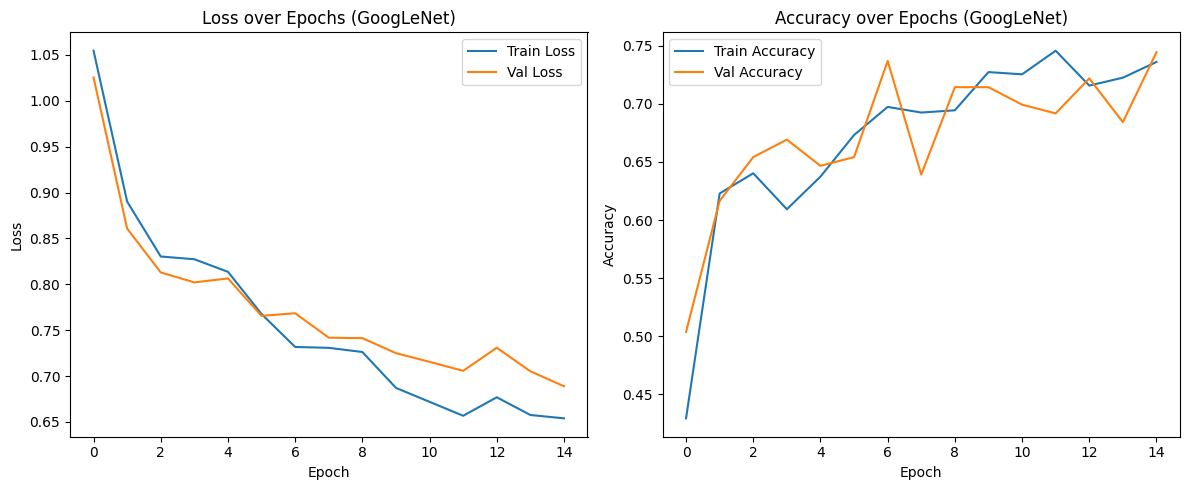

In [56]:
# Plot the results for each model
for model_name, results in model_results.items():
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(results['train_losses'], label='Train Loss')
    plt.plot(results['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over Epochs ({model_name})')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results['train_accuracies'], label='Train Accuracy')
    plt.plot(results['val_accuracies'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over Epochs ({model_name})')
    plt.legend()

    plt.tight_layout()
    plt.show()